- Metropolis
- lot of code less theory [Graphs]

- implement the non MF version 
- look at how it depends on the parameters

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as scp
from copy import deepcopy

In [2]:
# Parameters
L = 10  # Lenght of the edge of the image
N = L**2 # Number of spins 
p = 10 # Number of patterns
MF = 0 # Use or not the Mean Field strategy: if MF=1 uses MF, if MF = 0 only spins at
# a distance R interacts
R = 3 # The 3-nearest neighbor interacts
np.random.seed(1234) # Seed to make the random process reproducible

In [3]:
# Function that are in previous notebook
def random_patterns(N,p):
    xi = np.random.randint(0,2,N*p).reshape(p,N) # Each line is a pattern
    xi[xi==0]=-1
    return xi

def MF_coupling(xi,N):
    J = 1/N * np.array( [ (xi[:,i]*xi[:,j]).sum() for i in range(N) for j in range(N) ] )
    J = J.reshape(N,N)        
    for i in range(len(J)):
        J[i,i] = 0
    return J

def R_coupling(xi,N,R):
    J = MF_coupling(xi,N)
    for i in range( J.shape[0] ):
        J_temp = J[i].reshape(L,L)
        for j in range(L):
            y = (i%L -j)**2 # Look at indexes should be ok -1
            for k in range(L):
                if np.sqrt( (i//L - k)**2 + y ) > R: J_temp[j,k] = 0
        J[i] = J_temp.reshape(1,N)
    return J

def update(sys1):
    sys = deepcopy(sys1)
    N = len(sys)
    for i in range(N):
        temp = 0
        for j in range(N): #Maybe it is possible to set the cycle on J[i][j]!=0 only
            temp +=  J[i][j]*sys[j] 
        sys[i] = np.sign(temp)
    return np.sign(sys)

def deterministic_hopfield(sys1, t):
    sys = deepcopy(sys1)
    for i in range(t):
        sys = update(sys)
    return sys

def error_im(xi_idx, sys):
    wrong_pixels = (np.abs( sys-xi_idx )/2).sum()
    return wrong_pixels/len(sys)

def assign_pattern(xi,sys):
    errors = [ error_im(i,sys) for i in xi ]
    correct = np.argmin(errors)
    return correct

def total_error(xi,t):
    errors = []
    prediction = []
    for mu in range(len(xi)):
        sys = deterministic_hopfield(xi[mu],t)
        errors.append( error_im(xi[mu],sys) )
        if assign_pattern(xi,sys)==mu:
            prediction.append( 1 )
        else: prediction.append( 0 )
    errors = (np.array(errors)).mean()
    prediction = np.array(prediction).sum()/len(xi)
    return errors, prediction

def corrupt_uniform(sys, q): # q probability to flip the pixel
    sys_temp = deepcopy(sys)
    N = sys.shape[0]
    for i in range(N):
        r = np.random.rand()
        if r < q:
            sys_temp[i] *= -1
    return sys_temp

In [4]:
xi = random_patterns(N,p)
J = MF_coupling(xi,N)

In [7]:
def H(J,sys):
    N = sys.shape[0]
    energy = 0
    for i in range(N):
        for j in range(i):
            energy -= J[i][j]*sys[i]*sys[j]
    return energy

# Mean Field version of dH
def dH(J, sys, k): # k is the index of the spin flipped
    N = sys.shape[0]
    dh = 0
    for i in range(N):
        dh += sys[i]*J[k][i]
    dh *= 2*sys[k]
    return dh

def metropolis(J, sys1, k, B): # B = 1/kbT temperature of the system
    sys = deepcopy(sys1)
    dh = dH(J, sys, k)
    r = np.random.rand() # random variable between (0,1)
    if r < np.exp( -B*dh ):
        sys[k] = -sys[k]
    return sys
    
def montecarlo(J, sys1, B, t ): # t number of iteration of the montecarlo
    sys = deepcopy(sys1)
    N = sys.shape[0]
    for i in range(t):
        k = np.random.randint(0,N)
        sys = metropolis(J, sys, k, B)
    return sys

The error of the algorithm is 0.000000
The algorithm recognised the pattern 3 and the correct pattern is 3


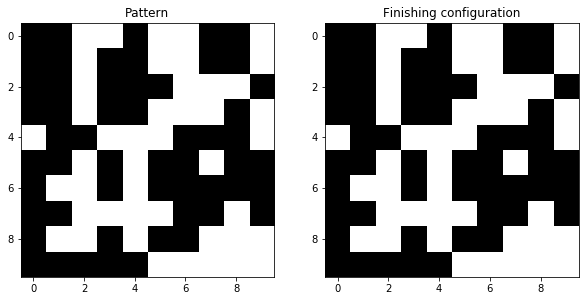

In [12]:
idx = 3

sys = montecarlo(J,xi[idx], 10, 1000)
wrong_pixels = error_im(xi[idx],sys)
assigned_pattern = assign_pattern(xi,sys)


fig, ax = plt.subplots(1,2, figsize = (10,6))
ax[0].set_title('Pattern')
ax[0].imshow(xi[idx].reshape(L,L), cmap='Greys')
ax[1].set_title('Finishing configuration')
ax[1].imshow(sys.reshape(L,L), cmap='Greys')
print('The error of the algorithm is %f' %(wrong_pixels))
print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,idx))

The error of the algorithm is 0.210000
The algorithm recognised the pattern 3 and the correct pattern is 3


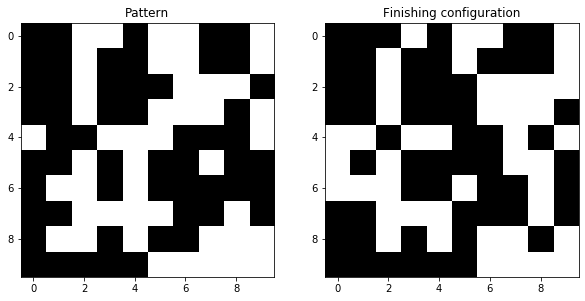

In [29]:
idx = 3

yi = corrupt_uniform(xi[idx], 0.35)

sys = montecarlo(J,yi, 10, 1000)
wrong_pixels = error_im(xi[idx],sys)
assigned_pattern = assign_pattern(xi,sys)


fig, ax = plt.subplots(1,2, figsize = (10,6))
ax[0].set_title('Pattern')
ax[0].imshow(xi[idx].reshape(L,L), cmap='Greys')
ax[1].set_title('Finishing configuration')
ax[1].imshow(sys.reshape(L,L), cmap='Greys')
print('The error of the algorithm is %f' %(wrong_pixels))
print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,idx))

In [19]:
error_im(xi[4],sys)

0.22